In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
exp_name = "exp_compass"
exp_number = "exp_debug"
base_path = "/Users/andreasathanasopoulos/Phd/projects/bayesian_fairness/"
data_path = base_path + "/my_code/Bayesian-fairness/data"
save_path = base_path + f"/my_code/Bayesian-fairness/results/continuous/{exp_name}/{exp_number}"

# load data


In [3]:
def encode_data(data,unique_values):
    encoded_value = np.array([])
    for i, d in data.iterrows():
        # encode feature to an index represents the unique value.
        index = np.argmax((d.values == unique_values).all(axis=1))
        encoded_value = np.append(encoded_value, index)
    return encoded_value.astype(int)

In [4]:
# set atributes
Z_atr = ["sex", "race"]
X_atr = ['age_cat', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'c_charge_degree']
Y_atr = 'two_year_recid'

# clip_features = ["juv_fel_count", "juv_misd_count", "juv_other_count", "priors_count"]

In [5]:
dataset = pd.read_csv(data_path + "/compas.csv")

In [6]:
# get distinct values
unique_z = np.unique(dataset[Z_atr].values, axis=0)
n_z = len(unique_z)

unique_y = np.unique(dataset[Y_atr].values, axis=0)
n_y = len(unique_y)

unique_x = np.unique(dataset[X_atr].values, axis=0)
n_x = len(unique_x)

In [7]:
print("Unique Z values:", n_z)
print("Unique X values:", n_x)
print("Unique Y values:", n_y)

Unique Z values: 12
Unique X values: 604
Unique Y values: 2


In [8]:
# # encode z for convenience
dataset["z"] = encode_data(dataset[Z_atr], unique_values=unique_z)
Z_atr = "z"
# # drop under represented index
# n_z = n_z - 1
# mask = np.logical_not(dataset[Z_atr] == 10)
# dataset = dataset[mask]

In [9]:
# maks_11 = dataset[Z_atr] == 11
# dataset.loc[maks_11,Z_atr] = 10 

In [10]:
# dataset.reset_index(inplace=True)

In [11]:
# unique_z = dataset["z"].unique()
# unique_z

In [12]:
# from sklearn.model_selection import StratifiedShuffleSplit
# train_size = 6000/dataset.shape[0]
# spliter = StratifiedShuffleSplit(n_splits=1, test_size=1-train_size, random_state=0)

In [13]:
# dataset = dataset.sample(frac=1,replace=False,ignore_index=True)

In [14]:
train_data = dataset.iloc[0:6000]
test_data = dataset.iloc[6000:]

In [15]:
# tmp = train_data.copy()
# train_data = test_data.copy()
# test_data = tmp

In [16]:
print("training size:", train_data.shape)
print("testing size:", test_data.shape)

training size: (6000, 10)
testing size: (1214, 10)


# model

In [17]:
def calc_freq(data, n):
    """ calculate frequency of 1D array"""
    P = np.zeros(n)
    for value in range(n):
        mask =  data == value
        P[value] = mask.mean()
    return P

def get_models(data):
    # Py, Pz_y
    N_y = np.zeros(n_y) + 0.5
    N_z_y = np.zeros((n_z,n_y)) + 0.5
    for i, datum in data.iterrows():
        N_y[datum[Y_atr]] += 1
        N_z_y[datum[Z_atr],datum[Y_atr]] += 1
    Py = N_y / np.sum(N_y)
    Pz_y = N_z_y/ np.sum(N_z_y, axis=0)
    
    # Py_x
    from sklearn.linear_model import LogisticRegression
    model_y_x = LogisticRegression(max_iter=1000)
    model_y_x.fit(X = data[X_atr], y = data[Y_atr])
    
    #Pz_yx
    unique_z_values = data[Z_atr].unique()
    missing_z = [z for z in range(12) if z not in unique_z_values]

    if missing_z:
        random_data = np.random.randint(low= 0 , high=2, size = (1, len(data.columns)))
        fake_df = pd.DataFrame(random_data,columns = data.columns)
        fake_df[Z_atr] = missing_z
        data = pd.concat([data, fake_df])
        print(missing_z)
    input_features = [Y_atr] + X_atr
    model_z_yx = LogisticRegression(max_iter=1000)
    model_z_yx.fit(X = data[input_features], y = data[Z_atr])
    
    return Py, Pz_y, model_y_x, model_z_yx

In [18]:
test_model = get_models(test_data)

[10]


# Train policy

In [19]:
num_X = n_x # number of features
num_Y = n_y # number of outcomes
num_Z = n_z # number of sensitive features
num_A = 2 # number of actions

In [20]:
# parameters
n_iter = 400 # number of itteration for SGD
lr = 1.0 # learning rate
l = 0.5 # lambda

# Functions

In [21]:
def get_eye_utility(size):
    return np.eye(size)

utility = get_eye_utility(size=2)

# Algorithm
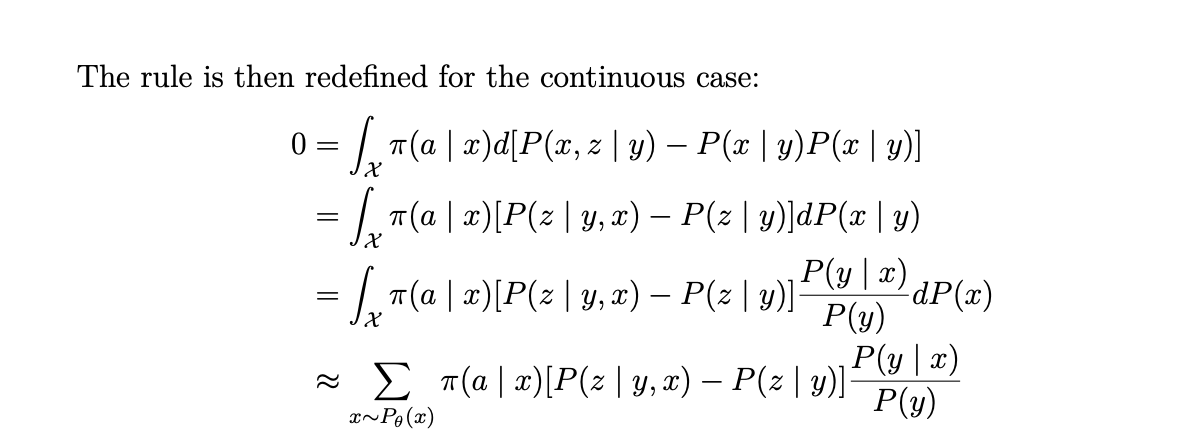

In [22]:
def get_fairness_loss(Pa_x, Py, Pz_y, model_y_x, model_z_yx):
    delta = (model_z_yx / Pz_y - 1 ) * (model_y_x / Py)
    delta = tf.reshape(delta,(-1,1))
    f =  Pa_x * delta
    
    return tf.math.abs(tf.math.reduce_mean(f)) * 10

In [23]:
def get_utility_loss(y_true, y_pred):
    utility = y_true * y_pred + (1 - y_true) * (1 - y_pred)
    neg_utility = - utility
    return tf.math.reduce_mean(neg_utility)

In [24]:
def get_utility_metric(y_true, y_pred):
    utility = y_true * y_pred + (1 - y_true) * (1 - y_pred)
    return tf.math.reduce_mean(utility)

In [25]:
import tensorflow as tf
from tensorflow.python.keras.engine import data_adapter


utility_tracker = tf.keras.metrics.Mean(name="utility")
fairness_tracker = tf.keras.metrics.Mean(name="fairness")
loss_tracker = tf.keras.metrics.Mean(name="loss")


class LogisticRegresionTF(tf.keras.Model):
    """
    logistic regresion model , tensorflow
    """
    def __init__(self, input_dim, l):
        super(LogisticRegresionTF, self).__init__()
        self.l = l
        
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(
            initial_value=w_init(shape=(input_dim, 1), dtype="float32"),
            trainable=True,
        )
        
        b_init = tf.zeros_initializer()
        self.b = tf.Variable(
            initial_value=b_init(shape=(), dtype="float32"),
            trainable=True
        )

    def call(self, inputs):
        return tf.nn.sigmoid(tf.matmul(inputs,self.w) + self.b)

    def train_step(self, data):
        x, y = data
        x, Py, Pz_y, model_y_x, model_z_yx = x[:,:6], x[:,6],x[:,7],x[:,8],x[:,9]
        # Run forward pass.
        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)
            tf.print(tf.shape(y_pred))
            tf.print(tf.shape(y))
            utility = get_utility_loss(y_true = y, y_pred = y_pred)
            fairness = get_fairness_loss(y_pred, Py, Pz_y, model_y_x, model_z_yx)
            loss = (1-self.l) * utility + self.l * fairness 
        tf.print(self.optimizer.learning_rate)

        self._validate_target_and_loss(y, loss)
        # Run backwards pass.
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
        # update metrics
        loss_tracker.update_state(loss)
        utility_tracker.update_state(get_utility_metric(y_true = y, y_pred = y_pred))
        fairness_tracker.update_state(fairness)
        
        metrics = self.compute_metrics(x, y, y_pred,None)
        metrics["fairness_loss"] = fairness_tracker.result()  
        metrics["utility"] = utility_tracker.result()
        metrics["loss"] = loss_tracker.result() 
#         tf.print(fairness_loss)
        return metrics
    
    @property
    def metrics(self):
        # We list our `Metric` objects here so that `reset_states()` can be
        # called automatically at the start of each epoch
        # or at the start of `evaluate()`.
        # If you don't implement this property, you have to call
        # `reset_states()` yourself at the time of your choosing.
        return [loss_tracker , fairness_tracker, utility_tracker] + self.compiled_metrics.metrics

In [26]:
Py, Pz_y, model_y_x, model_z_yx = get_models(train_data)

In [27]:
data_Py = [Py[y] for y in train_data[Y_atr].values]
data_Pz_y = [Pz_y[z, y] for z, y in train_data[[Z_atr,Y_atr]].values]

predicted_proba_Py_x = model_y_x.predict_proba(train_data[X_atr])
data_Py_z = np.zeros(train_data.shape[0])
for i, (ind, datum) in enumerate(train_data.iterrows()):
    data_Py_z[i] = predicted_proba_Py_x[i][datum[Y_atr]]
    
predicted_proba_Pz_yx = model_z_yx.predict_proba(train_data[[Y_atr] + X_atr])
data_Pz_yx = np.zeros(train_data.shape[0])
for i, (ind, datum) in enumerate(train_data.iterrows()):
    data_Pz_yx[i] = predicted_proba_Pz_yx[i][datum[Z_atr]]

In [28]:
train_data

,sex,age_cat,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,two_year_recid,z
0,0,2,0,0,0,0,0,1,0,0
1,0,1,1,0,0,0,0,1,1,1
2,0,0,1,0,0,1,4,1,1,1
3,0,0,1,0,1,0,1,1,0,1
4,0,1,0,0,0,0,2,1,0,0
...,...,...,...,...,...,...,...,...,...,...
5995,0,1,1,0,0,0,22,1,1,1
5996,1,1,0,0,0,0,0,1,1,6
5997,0,2,2,0,0,0,2,1,1,2
5998,0,1,1,0,0,0,5,0,0,1


In [29]:
# input_dataset = tf.data.Dataset.from_tensor_slices((train_data[X_atr].astype("float32").values,
#            data_Py,
#            data_Pz_y,
#            data_Py_z,
#            data_Pz_yx)
# )
# labels_dataset = tf.data.Dataset.from_tensor_slices(train_data[Y_atr])
# tf_train_dataset = tf.data.Dataset.zip((input_dataset, labels_dataset))
# tf_train_dataset.shuffle(1000).batch(64).repeat()

In [30]:
policy_model = LogisticRegresionTF(input_dim=len(X_atr), l = 0.0)

In [31]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)
policy_model.compile(optimizer=optimizer,
               metrics = ["accuracy"])

In [32]:
in_df = train_data[X_atr].astype("float32")
in_df["Py"] = data_Py
in_df["Pz_y"] = data_Pz_y
in_df["Py_z"] = data_Py_z
in_df["Pz_yx"] = data_Pz_yx

In [33]:
in_df

,age_cat,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,Py,Pz_y,Py_z,Pz_yx
0,2.0,0.0,0.0,0.0,0.0,1.0,0.550992,0.049064,0.806851,0.059295
1,1.0,0.0,0.0,0.0,0.0,1.0,0.449008,0.508704,0.330786,0.380325
2,0.0,0.0,0.0,1.0,4.0,1.0,0.449008,0.508704,0.690225,0.618515
3,0.0,0.0,1.0,0.0,1.0,1.0,0.550992,0.350694,0.436171,0.478386
4,1.0,0.0,0.0,0.0,2.0,1.0,0.550992,0.049064,0.598783,0.052283
...,...,...,...,...,...,...,...,...,...,...
5995,1.0,0.0,0.0,0.0,22.0,1.0,0.449008,0.508704,0.933514,0.837547
5996,1.0,0.0,0.0,0.0,0.0,1.0,0.449008,0.004630,0.330786,0.011815
5997,2.0,0.0,0.0,0.0,2.0,1.0,0.449008,0.241667,0.245004,0.401558
5998,1.0,0.0,0.0,0.0,5.0,0.0,0.550992,0.350694,0.524162,0.397598


In [34]:
history = policy_model.fit(x = in_df.astype("float32"),
                           y = train_data[Y_atr].astype("float32"),
                           epochs=400,
                           batch_size=train_data[Y_atr].shape[0]).history

Epoch 1/400
[6000 1]
[6000 1]
0.1


2023-01-25 17:14:18.057491: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 0s 193ms/step - loss: -0.5080 - fairness: 0.5986 - utility: 0.5080 - accuracy: 0.5822 - fairness_loss: 0.5986
Epoch 2/400
[6000 1]
[6000 1]
0.1
1/1 [==============================] - 0s 3ms/step - loss: -0.5136 - fairness: 0.6385 - utility: 0.5136 - accuracy: 0.5717 - fairness_loss: 0.6385
Epoch 3/400
[6000 1]
[6000 1]
0.1
1/1 [==============================] - 0s 3ms/step - loss: -0.5182 - fairness: 0.6692 - utility: 0.5182 - accuracy: 0.5743 - fairness_loss: 0.6692
Epoch 4/400
[6000 1]
[6000 1]
0.1
1/1 [==============================] - 0s 5ms/step - loss: -0.5217 - fairness: 0.6915 - utility: 0.5217 - accuracy: 0.5747 - fairness_loss: 0.6915
Epoch 5/400
[6000 1]
[6000 1]
0.1
1/1 [==============================] - 0s 5ms/step - loss: -0.5246 - fairness: 0.7077 - utility: 0.5246 - accuracy: 0.5755 - fairness_loss: 0.7077
Epoch 6/400
[6000 1]
[6000 1]
0.1
1/1 [==============================] - 0s 5ms/step - loss: -0.5269 - fairness: 0.7196 - utili

1/1 [==============================] - 0s 5ms/step - loss: -0.5627 - fairness: 0.7269 - utility: 0.5627 - accuracy: 0.6383 - fairness_loss: 0.7269
Epoch 47/400
[6000 1]
[6000 1]
0.1
1/1 [==============================] - 0s 6ms/step - loss: -0.5633 - fairness: 0.7255 - utility: 0.5633 - accuracy: 0.6383 - fairness_loss: 0.7255
Epoch 48/400
[6000 1]
[6000 1]
0.1
1/1 [==============================] - 0s 4ms/step - loss: -0.5639 - fairness: 0.7242 - utility: 0.5639 - accuracy: 0.6383 - fairness_loss: 0.7242
Epoch 49/400
[6000 1]
[6000 1]
0.1
1/1 [==============================] - 0s 4ms/step - loss: -0.5646 - fairness: 0.7228 - utility: 0.5646 - accuracy: 0.6383 - fairness_loss: 0.7228
Epoch 50/400
[6000 1]
[6000 1]
0.1
1/1 [==============================] - 0s 4ms/step - loss: -0.5652 - fairness: 0.7214 - utility: 0.5652 - accuracy: 0.6383 - fairness_loss: 0.7214
Epoch 51/400
[6000 1]
[6000 1]
0.1
1/1 [==============================] - 0s 3ms/step - loss: -0.5658 - fairness: 0.7200 - ut

1/1 [==============================] - 0s 4ms/step - loss: -0.5870 - fairness: 0.6712 - utility: 0.5870 - accuracy: 0.6663 - fairness_loss: 0.6712
Epoch 92/400
[6000 1]
[6000 1]
0.1
1/1 [==============================] - 0s 4ms/step - loss: -0.5874 - fairness: 0.6702 - utility: 0.5874 - accuracy: 0.6663 - fairness_loss: 0.6702
Epoch 93/400
[6000 1]
[6000 1]
0.1
1/1 [==============================] - 0s 4ms/step - loss: -0.5879 - fairness: 0.6692 - utility: 0.5879 - accuracy: 0.6665 - fairness_loss: 0.6692
Epoch 94/400
[6000 1]
[6000 1]
0.1
1/1 [==============================] - 0s 4ms/step - loss: -0.5883 - fairness: 0.6682 - utility: 0.5883 - accuracy: 0.6665 - fairness_loss: 0.6682
Epoch 95/400
[6000 1]
[6000 1]
0.1
1/1 [==============================] - 0s 4ms/step - loss: -0.5887 - fairness: 0.6673 - utility: 0.5887 - accuracy: 0.6665 - fairness_loss: 0.6673
Epoch 96/400
[6000 1]
[6000 1]
0.1
1/1 [==============================] - 0s 4ms/step - loss: -0.5891 - fairness: 0.6663 - ut

[6000 1]
[6000 1]
0.1
1/1 [==============================] - 0s 4ms/step - loss: -0.6029 - fairness: 0.6357 - utility: 0.6029 - accuracy: 0.6647 - fairness_loss: 0.6357
Epoch 137/400
[6000 1]
[6000 1]
0.1
1/1 [==============================] - 0s 3ms/step - loss: -0.6032 - fairness: 0.6351 - utility: 0.6032 - accuracy: 0.6647 - fairness_loss: 0.6351
Epoch 138/400
[6000 1]
[6000 1]
0.1
1/1 [==============================] - 0s 4ms/step - loss: -0.6035 - fairness: 0.6345 - utility: 0.6035 - accuracy: 0.6647 - fairness_loss: 0.6345
Epoch 139/400
[6000 1]
[6000 1]
0.1
1/1 [==============================] - 0s 3ms/step - loss: -0.6037 - fairness: 0.6339 - utility: 0.6037 - accuracy: 0.6647 - fairness_loss: 0.6339
Epoch 140/400
[6000 1]
[6000 1]
0.1
1/1 [==============================] - 0s 5ms/step - loss: -0.6040 - fairness: 0.6334 - utility: 0.6040 - accuracy: 0.6647 - fairness_loss: 0.6334
Epoch 141/400
[6000 1]
[6000 1]
0.1
1/1 [==============================] - 0s 3ms/step - loss: -0.6

1/1 [==============================] - 0s 5ms/step - loss: -0.6132 - fairness: 0.6151 - utility: 0.6132 - accuracy: 0.6637 - fairness_loss: 0.6151
Epoch 181/400
[6000 1]
[6000 1]
0.1
1/1 [==============================] - 0s 5ms/step - loss: -0.6134 - fairness: 0.6147 - utility: 0.6134 - accuracy: 0.6637 - fairness_loss: 0.6147
Epoch 182/400
[6000 1]
[6000 1]
0.1
1/1 [==============================] - 0s 5ms/step - loss: -0.6135 - fairness: 0.6144 - utility: 0.6135 - accuracy: 0.6637 - fairness_loss: 0.6144
Epoch 183/400
[6000 1]
[6000 1]
0.1
1/1 [==============================] - 0s 4ms/step - loss: -0.6137 - fairness: 0.6140 - utility: 0.6137 - accuracy: 0.6637 - fairness_loss: 0.6140
Epoch 184/400
[6000 1]
[6000 1]
0.1
1/1 [==============================] - 0s 3ms/step - loss: -0.6139 - fairness: 0.6137 - utility: 0.6139 - accuracy: 0.6637 - fairness_loss: 0.6137
Epoch 185/400
[6000 1]
[6000 1]
0.1
1/1 [==============================] - 0s 3ms/step - loss: -0.6141 - fairness: 0.6133

1/1 [==============================] - 0s 4ms/step - loss: -0.6203 - fairness: 0.6022 - utility: 0.6203 - accuracy: 0.6652 - fairness_loss: 0.6022
Epoch 225/400
[6000 1]
[6000 1]
0.1
1/1 [==============================] - 0s 3ms/step - loss: -0.6204 - fairness: 0.6020 - utility: 0.6204 - accuracy: 0.6652 - fairness_loss: 0.6020
Epoch 226/400
[6000 1]
[6000 1]
0.1
1/1 [==============================] - 0s 4ms/step - loss: -0.6206 - fairness: 0.6017 - utility: 0.6206 - accuracy: 0.6662 - fairness_loss: 0.6017
Epoch 227/400
[6000 1]
[6000 1]
0.1
1/1 [==============================] - 0s 4ms/step - loss: -0.6207 - fairness: 0.6015 - utility: 0.6207 - accuracy: 0.6662 - fairness_loss: 0.6015
Epoch 228/400
[6000 1]
[6000 1]
0.1
1/1 [==============================] - 0s 3ms/step - loss: -0.6208 - fairness: 0.6013 - utility: 0.6208 - accuracy: 0.6662 - fairness_loss: 0.6013
Epoch 229/400
[6000 1]
[6000 1]
0.1
1/1 [==============================] - 0s 4ms/step - loss: -0.6210 - fairness: 0.6011

1/1 [==============================] - 0s 4ms/step - loss: -0.6255 - fairness: 0.5937 - utility: 0.6255 - accuracy: 0.6662 - fairness_loss: 0.5937
Epoch 269/400
[6000 1]
[6000 1]
0.1
1/1 [==============================] - 0s 3ms/step - loss: -0.6256 - fairness: 0.5935 - utility: 0.6256 - accuracy: 0.6662 - fairness_loss: 0.5935
Epoch 270/400
[6000 1]
[6000 1]
0.1
1/1 [==============================] - 0s 4ms/step - loss: -0.6257 - fairness: 0.5934 - utility: 0.6257 - accuracy: 0.6662 - fairness_loss: 0.5934
Epoch 271/400
[6000 1]
[6000 1]
0.1
1/1 [==============================] - 0s 4ms/step - loss: -0.6258 - fairness: 0.5932 - utility: 0.6258 - accuracy: 0.6662 - fairness_loss: 0.5932
Epoch 272/400
[6000 1]
[6000 1]
0.1
1/1 [==============================] - 0s 3ms/step - loss: -0.6259 - fairness: 0.5930 - utility: 0.6259 - accuracy: 0.6662 - fairness_loss: 0.5930
Epoch 273/400
[6000 1]
[6000 1]
0.1
1/1 [==============================] - 0s 4ms/step - loss: -0.6260 - fairness: 0.5929

1/1 [==============================] - 0s 4ms/step - loss: -0.6295 - fairness: 0.5877 - utility: 0.6295 - accuracy: 0.6662 - fairness_loss: 0.5877
Epoch 313/400
[6000 1]
[6000 1]
0.1
1/1 [==============================] - 0s 3ms/step - loss: -0.6296 - fairness: 0.5876 - utility: 0.6296 - accuracy: 0.6662 - fairness_loss: 0.5876
Epoch 314/400
[6000 1]
[6000 1]
0.1
1/1 [==============================] - 0s 4ms/step - loss: -0.6297 - fairness: 0.5875 - utility: 0.6297 - accuracy: 0.6662 - fairness_loss: 0.5875
Epoch 315/400
[6000 1]
[6000 1]
0.1
1/1 [==============================] - 0s 4ms/step - loss: -0.6298 - fairness: 0.5874 - utility: 0.6298 - accuracy: 0.6662 - fairness_loss: 0.5874
Epoch 316/400
[6000 1]
[6000 1]
0.1
1/1 [==============================] - 0s 4ms/step - loss: -0.6299 - fairness: 0.5873 - utility: 0.6299 - accuracy: 0.6662 - fairness_loss: 0.5873
Epoch 317/400
[6000 1]
[6000 1]
0.1
1/1 [==============================] - 0s 4ms/step - loss: -0.6299 - fairness: 0.5872

1/1 [==============================] - 0s 3ms/step - loss: -0.6327 - fairness: 0.5834 - utility: 0.6327 - accuracy: 0.6662 - fairness_loss: 0.5834
Epoch 357/400
[6000 1]
[6000 1]
0.1
1/1 [==============================] - 0s 4ms/step - loss: -0.6328 - fairness: 0.5833 - utility: 0.6328 - accuracy: 0.6662 - fairness_loss: 0.5833
Epoch 358/400
[6000 1]
[6000 1]
0.1
1/1 [==============================] - 0s 3ms/step - loss: -0.6328 - fairness: 0.5833 - utility: 0.6328 - accuracy: 0.6662 - fairness_loss: 0.5833
Epoch 359/400
[6000 1]
[6000 1]
0.1
1/1 [==============================] - 0s 4ms/step - loss: -0.6329 - fairness: 0.5832 - utility: 0.6329 - accuracy: 0.6662 - fairness_loss: 0.5832
Epoch 360/400
[6000 1]
[6000 1]
0.1
1/1 [==============================] - 0s 4ms/step - loss: -0.6330 - fairness: 0.5831 - utility: 0.6330 - accuracy: 0.6662 - fairness_loss: 0.5831
Epoch 361/400
[6000 1]
[6000 1]
0.1
1/1 [==============================] - 0s 4ms/step - loss: -0.6330 - fairness: 0.5830

1/1 [==============================] - 0s 5ms/step - loss: -0.6353 - fairness: 0.5802 - utility: 0.6353 - accuracy: 0.6658 - fairness_loss: 0.5802


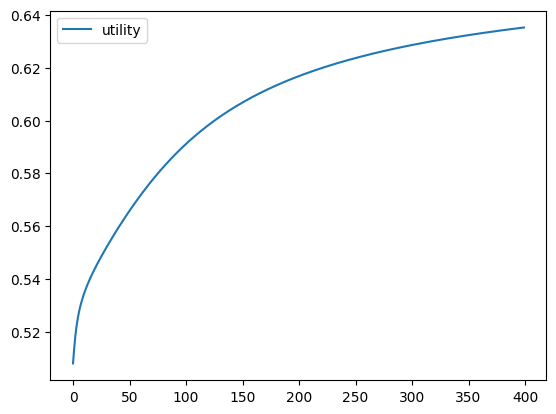

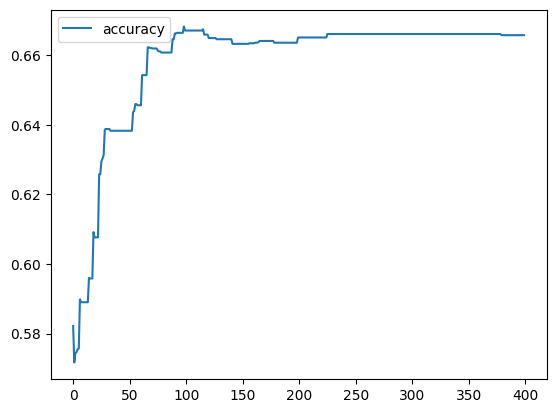

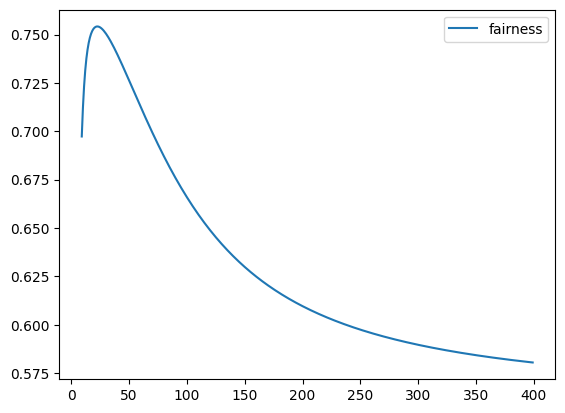

In [35]:
plt.figure()
plt.plot(history["utility"],label="utility")
# plt.plot(history["val_loss"],label="val_loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(history["accuracy"],label="accuracy")
# plt.plot(history["val_accuracy"],label="val_accuracy")
plt.legend()
plt.show()

plt.figure()
plt.plot(pd.DataFrame(history["fairness_loss"]).rolling(10).mean(),label="fairness")
# plt.plot(history["val_accuracy"],label="val_accuracy")
plt.legend()
plt.show()

In [36]:
history["fairness_loss"]

[0.598649799823761,
 0.6385427713394165,
 0.669213056564331,
 0.6915369033813477,
 0.7076984643936157,
 0.7195566892623901,
 0.7284072637557983,
 0.7351138591766357,
 0.7402530312538147,
 0.7442175149917603,
 0.7472807168960571,
 0.7496379613876343,
 0.7514322400093079,
 0.7527703046798706,
 0.7537331581115723,
 0.75438392162323,
 0.7547721266746521,
 0.7549375295639038,
 0.7549118399620056,
 0.7547216415405273,
 0.7543884515762329,
 0.7539305686950684,
 0.753363311290741,
 0.752699613571167,
 0.7519508004188538,
 0.7511264681816101,
 0.7502353191375732,
 0.749284029006958,
 0.7482799887657166,
 0.7472279071807861,
 0.7461336851119995,
 0.7450016736984253,
 0.7438356280326843,
 0.7426396012306213,
 0.7414168119430542,
 0.7401701211929321,
 0.7389023900032043,
 0.7376160621643066,
 0.7363134622573853,
 0.7349968552589417,
 0.7336679100990295,
 0.7323285937309265,
 0.7309805750846863,
 0.7296251058578491,
 0.7282636165618896,
 0.7268978357315063,
 0.7255287170410156,
 0.7241573333740234,

# Metrics

# empirical utility

In [37]:
p_a1 = policy_model.predict(in_df[X_atr])
p_a0 = 1 - p_a1
p_a_x = np.concatenate([p_a0, p_a1],axis=1).T
ys = train_data[[Y_atr]].values.ravel()
a_pred = np.argmax(p_a_x, axis=0)

188/188 [==============================] - 0s 257us/step


In [38]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true =  ys, y_pred=a_pred)

0.6658333333333334

In [39]:
def empirical_utility_v1(p_a_x, ys, utility):
    EU = 0
    for x, y in enumerate(ys):
        for a in range(2):
            EU += utility[a,y]* p_a_x[a, x]
    EU = EU / ys.shape[0]
    return EU

def empirical_utility_v2(p_a_x, ys, a, utility):
    EU = 0
    for x, (y, a) in enumerate(zip(ys, a)):
        EU += utility[a, y]* p_a_x[a, x]
    EU = EU / ys.shape[0]
    return EU

In [40]:
empirical_utility_v1(p_a_x, ys, utility)

0.6353176755892733

In [41]:
empirical_utility_v2(p_a_x, ys, a_pred, utility)

0.5671784182985624

In [42]:
p_a_x

array([[0.98540455, 0.9355259 , 0.11401039, ..., 0.93719435, 0.20497066,
        0.96945685],
       [0.01459542, 0.06447411, 0.8859896 , ..., 0.06280564, 0.79502934,
        0.03054316]], dtype=float32)

# empirical fairness

In [43]:
def empirical_fairness_v21(datas, model, policy):
    
    Z = 11

    EF = 0
    for z in range(Z):
        c = 0
        for i,(x, y) in datas.iterrows():
            delta = (model.Pz_yx[z, y, x]/model.Pz_y[z, y] - 1 )/(model.Py[y])
            c += policy[:, x] * delta
        c = c/datas.shape[0]
        c = np.linalg.norm(c, 1)
        EF += c
    return EF

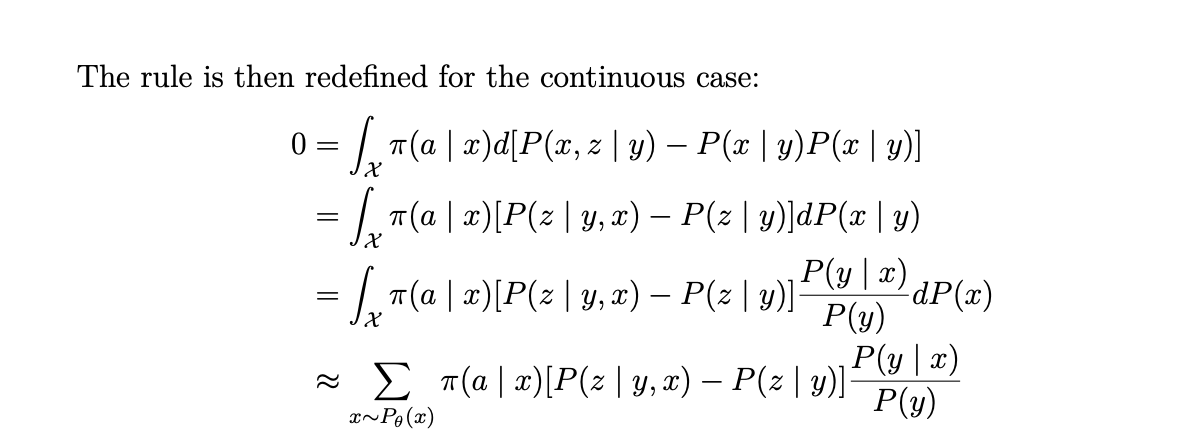

In [44]:
Py, Pz_y, model_y_x, model_z_yx

(array([0.5509915, 0.4490085]),
 array([[4.90640097e-02, 3.75925926e-02],
        [3.50694444e-01, 5.08703704e-01],
        [2.79438406e-01, 2.41666667e-01],
        [8.52958937e-02, 6.01851852e-02],
        [6.49154589e-03, 2.40740741e-03],
        [2.26449275e-03, 2.40740741e-03],
        [1.25301932e-02, 4.62962963e-03],
        [1.03411836e-01, 6.98148148e-02],
        [9.31461353e-02, 6.16666667e-02],
        [1.67572464e-02, 9.44444444e-03],
        [4.52898551e-04, 5.55555556e-04],
        [4.52898551e-04, 9.25925926e-04]]),
 LogisticRegression(max_iter=1000),
 LogisticRegression(max_iter=1000))

In [45]:
def empirical_fairness_cont_v11(datas, p_a_x, Pz_y, Py, model_y_x, model_z_yx):
    Z = n_z

    Py_x = model_y_x.predict_proba(datas[X_atr]).T
    EF = 0
    for y in range(2):
        tmp_data = datas[[Y_atr] + X_atr].copy()
        tmp_data[Y_atr] = y
        Pz_yx = model_z_yx.predict_proba(tmp_data[[Y_atr] + X_atr]).T
        print(Pz_yx.shape)
        for z in range(Z):
            c = 0
            for i in range(tmp_data.shape[0]):
                delta = (Pz_yx[z, i] - Pz_y[z, y] ) * (Py_x[y, i]/Py[y])
                c += p_a_x[:, i] * delta
            c = c/tmp_data.shape[0]
            c = np.linalg.norm(c, 1)
            EF += c
    return EF


def empirical_fairness_cont_v12(datas, p_a_x, Pz_y, Py,model_y_x, model_z_yx):
    Z = n_z

    Py_x = model_y_x.predict_proba(datas[X_atr]).T
    EF = 0
    for y in range(2):
        tmp_data = datas[[Y_atr] + X_atr].copy()
        tmp_data[Y_atr] = y
        Pz_yx = model_z_yx.predict_proba(tmp_data[[Y_atr] + X_atr]).T
        for z in range(Z):
            c = 0
            j= 0 
            for i in range(tmp_data.shape[0]):
                j = j + 1
                delta = (Pz_yx[z, i] / Pz_y[z, y] - 1 ) * (Py_x[y, i] / (Py[y]) )
                c += p_a_x[:, i] * delta
            c = c/datas.shape[0]
            c = np.linalg.norm(c, 1)
            EF += c
    return EF

In [54]:
datas = train_data
datas.shape

(6000, 10)

In [55]:
p_a1 = policy_model.predict(datas[X_atr].astype("float32"))
p_a0 = 1 - p_a1
p_a_x = np.concatenate([p_a0, p_a1],axis=1).T

188/188 [==============================] - 0s 263us/step


In [56]:
Py, Pz_y, model_y_x, model_z_yx = get_models(datas)
empirical_fairness_cont_v11(datas = datas, p_a_x = p_a_x, Pz_y=Pz_y, Py=Py, model_y_x = model_y_x, model_z_yx = model_z_yx )

(12, 6000)
(12, 6000)


0.29505915776462643

In [57]:
Py, Pz_y, model_y_x, model_z_yx = get_models(datas)
empirical_fairness_cont_v12(datas = datas,
                            p_a_x = p_a_x,
                            Pz_y = Pz_y,
                            Py = Py,
                            model_y_x = model_y_x, 
                            model_z_yx = model_z_yx )

5.384759895503521

# vectorize implementation empirical fairness

In [61]:
train_data.sample(frac=1.0,replace=True).reset_index(drop=True)

,sex,age_cat,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,two_year_recid,z
0,0,2,3,0,0,0,0,0,0,3
1,0,2,1,0,0,0,9,0,1,1
2,1,2,2,0,0,0,2,1,1,8
3,0,1,1,0,0,0,1,0,0,1
4,0,1,2,0,0,0,0,1,0,2
...,...,...,...,...,...,...,...,...,...,...
5995,0,1,1,0,0,0,4,0,0,1
5996,0,1,0,0,0,0,0,0,0,0
5997,0,1,1,0,0,0,6,1,1,1
5998,0,1,2,0,0,0,0,1,0,2


# evaluate

In [ ]:
def get_fairness(policy, model_delta):
    (X, Y, Z) = model_delta.shape
    fairness = 0
    for y in range(Y):
        for z in range(Z):
            delta = np.matmul(policy, model_delta[:, y , z ])
            fairness += np.linalg.norm(delta, 1)
    return fairness

In [ ]:
def get_utility(policy, model, utility):
    """
    Calculate expected utility
    Todo: vectorize operation - minor
    """
    A, X = policy.shape
    Y = A
    Eu = 0
    for x in range(X):
        for y in range(Y):
            for a in range(A):
                Eu += utility[a,y] * policy[a,x] * model.Pxy[x, y]
                
    return Eu

In [ ]:
data_Py = [Py[y] for y in train_data[Y_atr].values]
data_Pz_y = [Pz_y[z, y] for z, y in train_data[[Z_atr,Y_atr]].values]

predicted_proba_Py_x = model_y_x.predict_proba(train_data[X_atr])
data_Py_z = np.zeros(train_data.shape[0])
for i, datum in train_data.iterrows():
    data_Py_z[i] = predicted_proba_Py_x[i][datum[Y_atr]]
    
predicted_proba_Pz_yx = model_z_yx.predict_proba(train_data[[Y_atr] + X_atr])
data_Pz_yx = np.zeros(train_data.shape[0])
for i, datum in train_data.iterrows():
    data_Pz_yx[i] = predicted_proba_Pz_yx[i][datum[Z_atr]]

In [ ]:
p_a_x

In [ ]:
prob_columns
p_a_x = p_a_x.T

In [ ]:
C = 0
for i, (py, pz_y, py_z, pz_yx) in enumerate(in_df[prob_columns].values): 
    delta =  (pz_yx - pz_y) * (py_z / py)
    for a in range(2):
        C += p_a_x[a,i] * np.abs(delta)

In [ ]:
C / 6000

In [ ]:
p_a_x[a,i]

In [ ]:
in_df.columns

In [ ]:
prob_columns = ['Py', 'Pz_y', 'Py_z', 'Pz_yx']
in_df[prob_columns].values

In [ ]:
pa_x

In [ ]:
data_Py_z

In [ ]:
Py, Pz_y

In [ ]:
predicted_proba_Py_x = model_y_x.predict_proba(train_data[X_atr])

In [ ]:
predicted_proba_Py_x = predicted_proba_Py_x.T

In [ ]:
predicted_proba_Pz_yx.T

In [ ]:
Pz_y[z,y]

In [ ]:
C = 0
for y in range(len(unique_y)):
    train_data[Y_atr] = y
    pz_yix = model_z_yx.predict_proba(train_data[[Y_atr] + X_atr]).T
    for z in range(len(unique_y)):
        c = 0 
        for x, p_a in enumerate(p_a_x):
            delta = (pz_yix[z, x] - Pz_y[z,y])*(predicted_proba_Py_x[y, x] / Py[y])
            delta = np.abs(delta)
            for a in range(2):
                c += p_a[a] * np.abs(delta)
        c = c
        C += c 

In [ ]:
delta

In [ ]:
c/(6000*2)

In [ ]:
p_a_x

In [ ]:
enumerate(p_a_x)

In [ ]:
p_a_x

In [ ]:
pz_yx[z,x]

In [ ]:
np.ldelta

In [ ]:
p_a1 = policy.predict(in_df[X_atr])
p_a0 = 1 - p_a1
p_a_x = np.concatenate([p_a0,p_a1],axis=1)

In [ ]:
EF = 0 
for p_a, y in zip(p_a_x, train_data[Y_atr].values):
    for a in range(2):
        EU += utility[a,y] * p_a[a]
EU = EU/train_data.shape[0]

In [ ]:
def get_empirical_fairness(policy, y_array, utility):
    EF = 0 
    for p_a, y in zip(policy, y_array):
        for a in range(2):
            EU += utility[a,y] * p_a[a]
    EU = EU/train_data.shape[0]
    return EU

In [ ]:
def get_empirical_utility2(policy, y_array, utility):
    EU = 0 
    for p_a in policy:
        for y in range(2):
            for a in range(2):
                EU += utility[a, y] * p_a[a]
    EU = EU/train_data.shape[0]
    return EU

In [ ]:
def get_empirical_utility(policy, y_array, utility):
    EU = 0 
    for p_a, y in zip(policy, y_array):
        for a in range(2):
            EU += utility[a,y] * p_a[a]
    EU = EU/train_data.shape[0]
    return EU

In [ ]:
get_empirical_utility(p_a_x,train_data[Y_atr].values,utility)

In [ ]:
get_empirical_utility2(p_a_x, train_data[Y_atr].values,utility)

In [ ]:
a = np.argmax(p_a_x,axis=1)

In [ ]:
EU = 0 
for p_a,y in zip(p_a_x, train_data[Y_atr].values):
    for a in range(2):
        EU += utility[a,y] * p_a[a]
EU = EU/train_data.shape[0]

In [ ]:
utility

In [ ]:
EU

In [ ]:
p_a_x[x, a]

In [ ]:
train_data[Y_atr]

In [ ]:
in_df

In [ ]:
policy.history

In [ ]:
policy.evaluate(test_data[X_atr].astype("float32"),
                test_data[Y_atr])

In [ ]:
tf.matmul(train_data[X_atr].astype("float32"), policy.w)

In [ ]:
policy.predict(train_data[X_atr].astype("float32"))

#### fairness functions

#### utility functions

#### opt functions

In [ ]:
def evaluate(true_model, true_model_delta, policy, utility, l):
    """
    Evaluate policy on true model
    """
    results = {}
    results["fairness"] = np.round(get_fairness(policy, true_model_delta),4)
    results["utility"] = get_utility(policy, true_model, utility)
    results["total"] = (1 - l) * results["utility"] - l * results["fairness"]
    return results

In [ ]:
def update_policy(policy, model, utility, l, lr, n_iter):
    """
    Marginal Policy Dirichlet
    """
    model.get_marginal_model()
    model_delta = get_delta(model.Px_y, model.Px_yz)
    
    for i in range(n_iter):
        fairness_gradient = get_fairness_gradient(policy, model_delta)
        utility_gradient = get_utility_gradient(policy, model, utility)
        gradient = (1 - l) * utility_gradient #+ l * fairness_gradient # minus on the gradient calc.
        gradient = project_gradient(gradient)
        policy = policy + lr * gradient # maximize Utility & minimize fairness constrain.
        policy = normilize_policy(policy)
    
    return policy

In [ ]:
def update_policy_bayesian(policy, model, utility, l, lr, n_iter, n_model):
    """
    Marginal Policy Dirichlet
    """
    models = []
    model_delta = []
    for m in range(n_model):
        models += [model.sample_model()]
        model_delta += [get_delta(model.Px_y, model.Px_yz)]
    
    for i in range(n_iter):
        tmp_index = i%n_model
        tmp_model = models[tmp_index]
        tmp_delta = model_delta[tmp_index]
        fairness_gradient = get_fairness_gradient(policy, tmp_delta)
        utility_gradient = get_utility_gradient(policy, tmp_model, utility)
        gradient = (1 - l) * utility_gradient + l * fairness_gradient # minus on the gradient calc.
        gradient = project_gradient(gradient)
        policy = policy + lr * gradient # maximize Utility & minimize fairness constrain.
        policy = normilize_policy(policy)
    
    return policy

In [ ]:
# reproduce results
stop

In [ ]:
def load_org_policy(org_path_results):
    file = pd.read_csv(org_path_results + "/policy.csv")
    p_1 = file.iloc[4].values
    p_2 = file.iloc[5].values
    p_1 = [float(x) for x in p_1[0].split(" ")[1:]]
    p_2 = [float(x) for x in p_2[0].split(" ")[1:]]
    return np.array([p_1, p_2])
# [float(x) for x in p_1[0].split(" ")[1:]]

In [ ]:
org_path_results = "/Users/andreasathanasopoulos/Phd/projects/bayesian_fairness/org_code/bayesian-fairness/src/octave"
policy = load_org_policy(org_path_results)
policy.shape

In [ ]:
l

In [ ]:
steps = horizon // update_policy_period

results = []
for step in range(steps):    
    # update policy step
    policy = update_policy_bayesian(policy, belief, utility, l, lr, n_iter, n_model= n_samples) # SDG to update policy
    
    # evaluation step
    step_results = evaluate(true_dirichlet_model, true_model_delta, policy, utility, l)
    results += [step_results]
    
    # update belief step
    data_start_index = step * update_policy_period
    data_stop_index = min(data_start_index + update_policy_period, horizon)
    belief.update_posterior_belief(train_data.iloc[data_start_index : data_stop_index])
    
    print(f"--- Step : {data_start_index + 1} \n  ------- {step_results}")
    

In [ ]:
pd_resutls = pd.DataFrame(results)

# plots

In [ ]:
pd_resutls[["utility"]].plot()

In [ ]:
org = pd.read_csv(org_path_results + "/results.csv")

In [ ]:
def fix_results(r):
    new_r = [float(sr.split(" ")[1]) for sr in r]
    return new_r

r1 = fix_results(org.iloc[9: 64 + 9 - 3]["# Created by Octave 6.2.0"].values)
r2 = fix_results(org.iloc[74: 64 + 74 - 3]["# Created by Octave 6.2.0"].values)
r3 = fix_results(org.iloc[139: 64 + 139 - 3]["# Created by Octave 6.2.0"].values)
# r4 = fix_results(org.iloc[204: 64 + 204]["# Created by Octave 6.2.0"].values)

org_pd = pd.DataFrame([r1,r2,r3]).T
org_pd.columns = ["utility","total","fairness"]

In [ ]:
org_pd

In [ ]:
org_pd["utility"].plot()
pd_resutls["utility"].plot()

In [ ]:
org_pd["fairness"].plot()
pd_resutls["fairness"].plot()

In [ ]:
org_pd["total"].plot()
pd_resutls["total"].plot()

# Questions

In [ ]:
1. ProjectPolicyGradient ???